In [3]:
from pathlib import Path
import sys

# Get the path of the project root
project_root = Path.cwd().parent

# Append the project root to the system path
sys.path.append(str(project_root))

In [33]:
# Import custom functions
from src.utils.utility import load_config
from src.utils.models import evaluate_model
from src.utils.time_series import check_stationarity
from src.utils.seasonality import qs_test
from src.nowcast_models.autoregressive import apply_autoregression
from src.visualisation.visualise import plot_ar_results

In [15]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm
from pandas.plotting import lag_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import acf, graphics, pacf , ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor


In [6]:
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(14, 6))
sns.mpl.rc("font", size=14)

### Load Data


In [7]:
gdp_file_name = "gdp_clean.csv"
processed_data_path = Path.cwd().parent / "data" / "processed"
file_path = processed_data_path / gdp_file_name
gdp_df = pd.read_csv(file_path, parse_dates=["date"], index_col="date")

gdp_df.head()

,value
date,
2000-01-01,403407
2000-04-01,406049
2000-07-01,408120
2000-10-01,409871
2001-01-01,413381


In [8]:
gdp_df.shape

(94, 1)

### Select Best Lag


In [9]:
gdp_df.index.freq = gdp_df.index.inferred_freq

In [10]:
# tmp = gdp_df.copy()
# for ilag in range(1, 5):
#     tmp.loc[:, f"lag_{ilag}"] = gdp_df["value"].shift(ilag)
#     tmp = tmp.dropna()
#     y = tmp["value"]
#     X = tmp[["lag_" + str(i) for i in range(1, ilag + 1)]]
#     X = sm.add_constant(X)

#     m1 = sm.OLS(y, X).fit()
#     m2 = AutoReg(gdp_df, ilag).fit()
#     m3 = ARIMA(gdp_df, order=(ilag, 0, 0)).fit()

#     print(f"OLS LAG:{ilag} AIC:{round(m1.bic,2)}")
#     print(f"AutoReg LAG:{ilag} AIC:{round(m2.bic,2)}")
#     print(f"ARIMA LAG:{ilag} AIC:{round(m3.bic,2)} \n")

### Autoregressive Model


In [11]:
config = load_config(
    "/Users/jacopobarone/Desktop/data_projects/nowcasting_uk_gdp/config/model_config.json"
)

train_data, pred = apply_autoregression(gdp_df, config, max_lag=5)

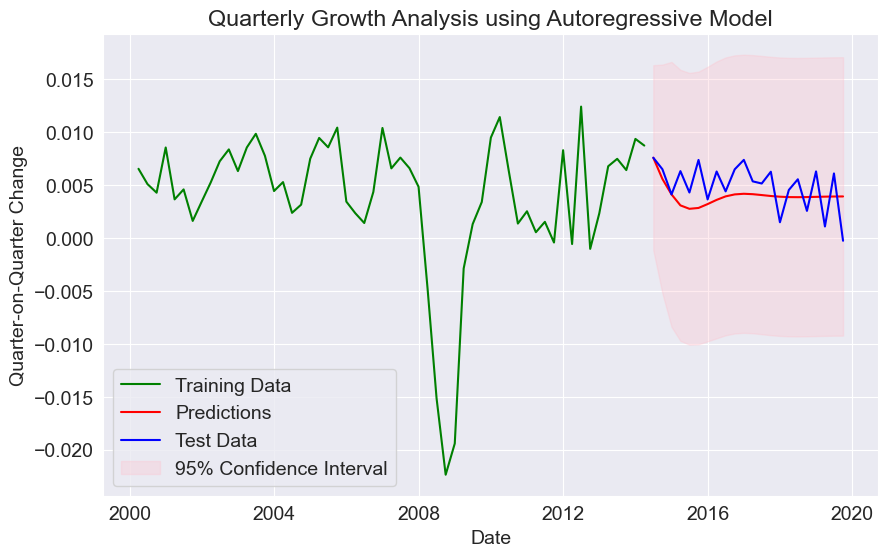

In [12]:
plot_ar_results(train_data, pred, True)

In [13]:
mse, r_squared = evaluate_model(pred["Actual"], pred["Prediction"])

print(f"MSE: {mse}\n")
print(f"R squared: {r_squared:.2f}")

MSE: 5.116040949214551e-06

R squared: -0.18


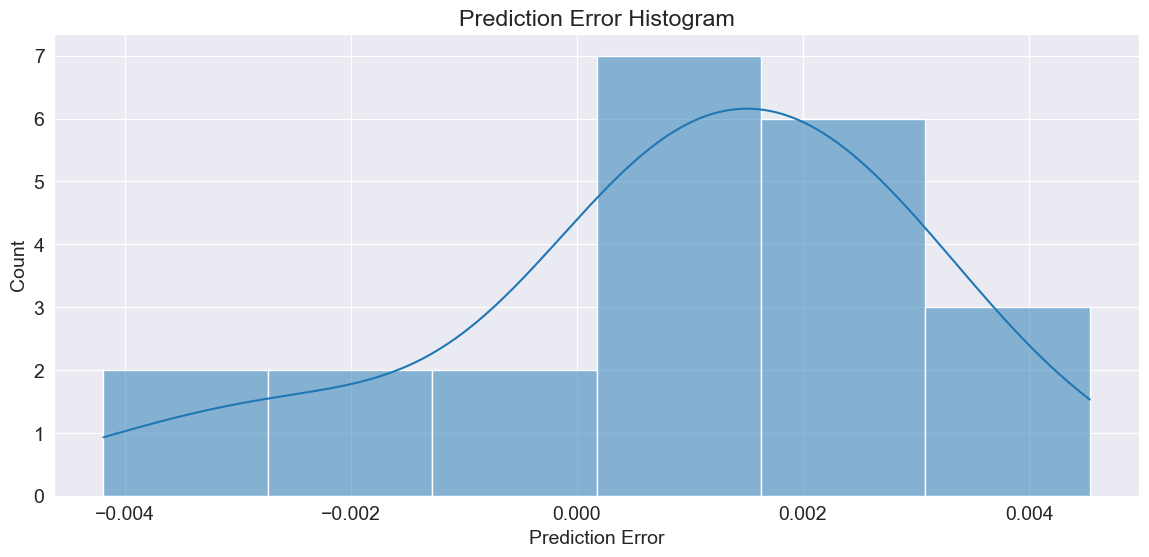

In [19]:
errors = pred['Actual'] - pred['Prediction']
sns.histplot(errors, kde=True)
plt.xlabel('Prediction Error')
plt.title('Prediction Error Histogram')
plt.show()


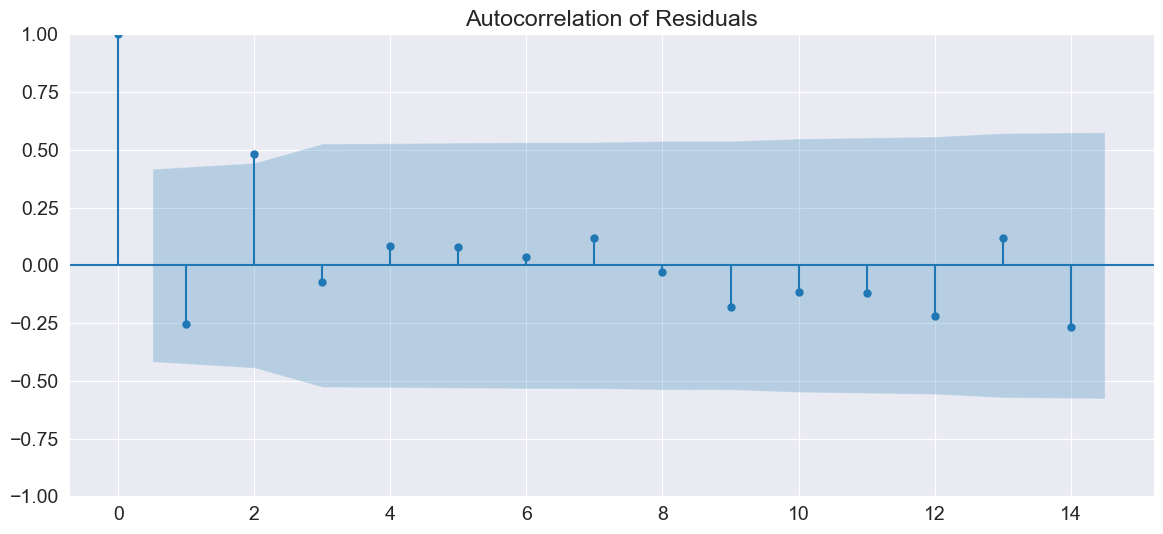

In [20]:
plot_acf(errors)
plt.title('Autocorrelation of Residuals')
plt.show()

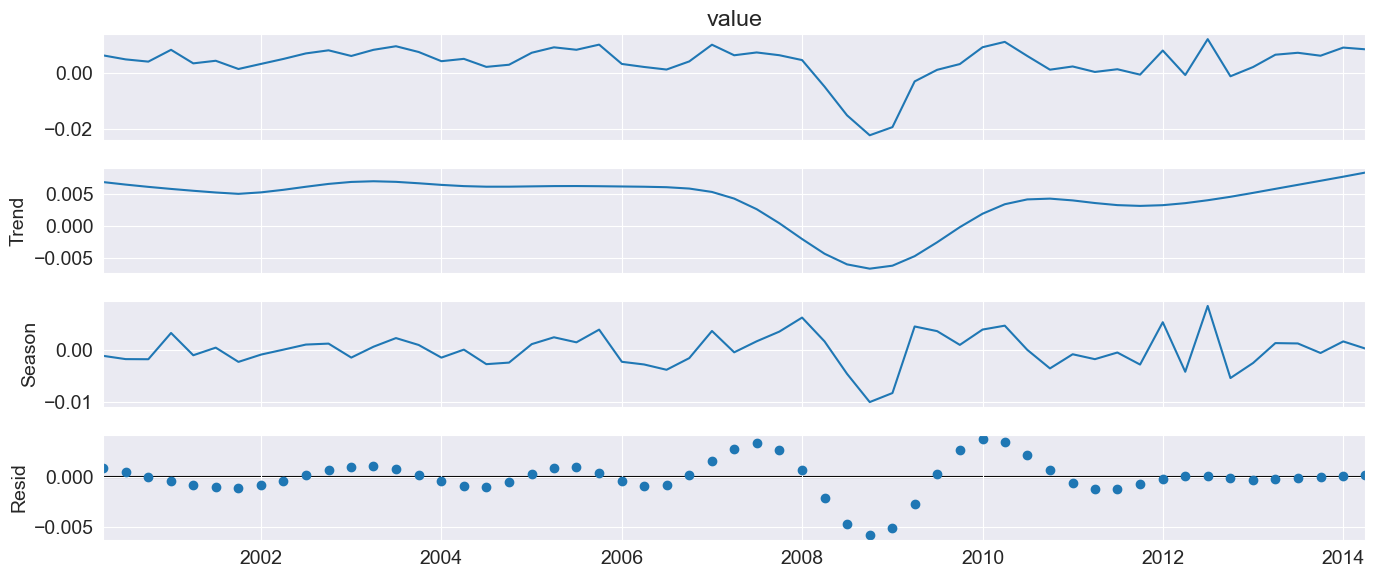

In [16]:
# Seasonal Decomposition using STL
stl = STL(train_data, seasonal=3)
result = stl.fit()

# Plot the decomposition components
fig = result.plot()
plt.show()

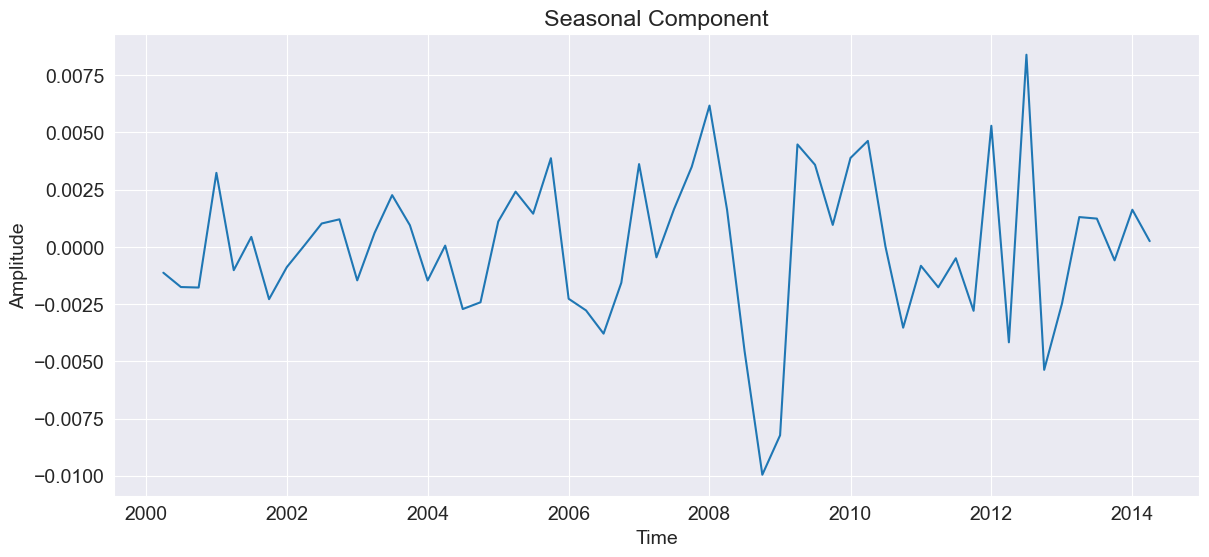

In [17]:
# Visualize the seasonal component
seasonal_component = result.seasonal
plt.plot(seasonal_component)
plt.title("Seasonal Component")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [34]:
seasonal_lag = 4  # Example: For quarterly data with quarterly seasonality
qs_statistic, p_value = qs_test(train_data, seasonal_lag)
print(f"QS Statistic: {qs_statistic}")
print(f"P-Value: {p_value}")

QS Statistic: 7.735247227285708e-11
P-Value: 0.9999999999613237


In [31]:
# Statistical Test for Seasonality (Augmented Dickey-Fuller Test)
adf_results, _ = check_stationarity(train_data)
adf_stats = adf_results["ADF Statistic"]
p_val = adf_results["p-value"]
crit_vals = adf_results["Critical Values"]

print(f"ADF Statistic: {adf_stats}")
print(f"p-value: {p_val}")
print("Critical Values:")
for key, value in crit_vals.items():
    print(f"{key}: {value}")

if p_val <= 0.05:
    print(
        "ADF Test Result: The data has no unit root, and it is stationary (reject the null hypothesis of non-stationarity)."
    )
else:
    print(
        "ADF Test Result: The data has a unit root and may not be stationary (fail to reject the null hypothesis of non-stationarity)."
    )

ADF Statistic: -3.8835061258350896
p-value: 0.0021596424754314436
Critical Values:
1%: -3.55770911573439
5%: -2.9167703434435808
10%: -2.59622219478738
ADF Test Result: The data has no unit root, and it is stationary (reject the null hypothesis of non-stationarity).


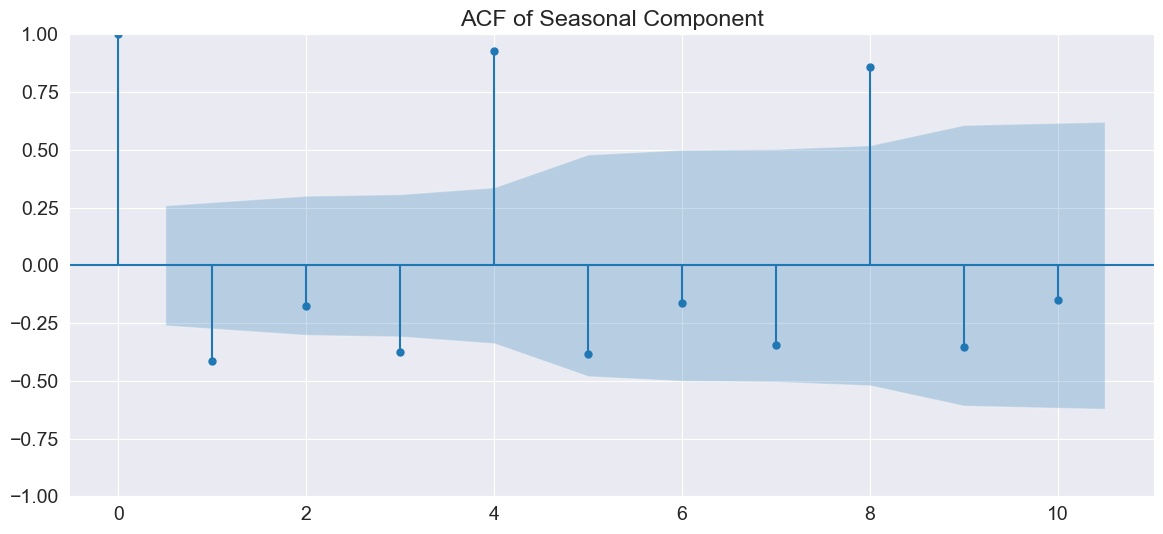

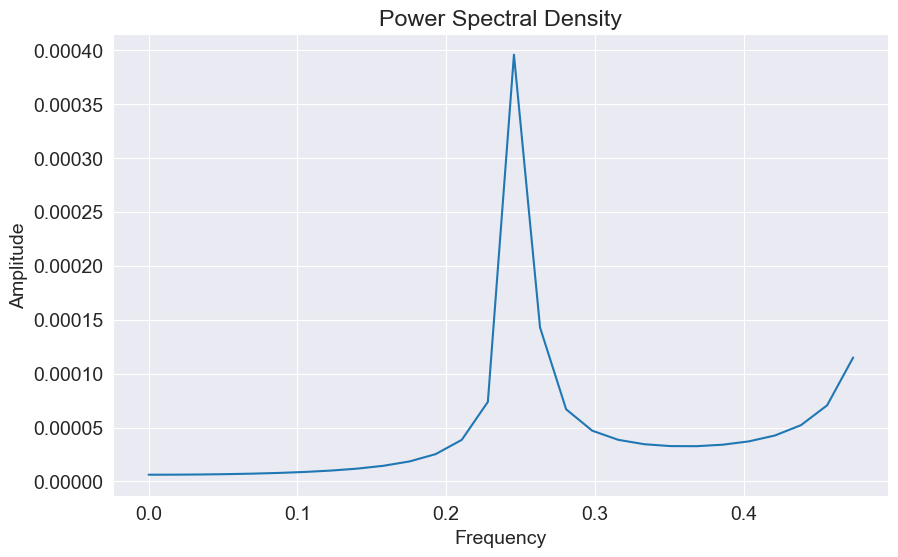

In [32]:
# Step 1: Decompose the time series to extract the seasonal component
decomposition = sm.tsa.seasonal_decompose(train_data, model="additive")

# Extract the seasonal component
seasonal_component = decomposition.seasonal.dropna()

# Step 2: Calculate and plot the autocorrelation function (ACF)
acf = sm.graphics.tsa.plot_acf(seasonal_component, lags=10)
plt.title("ACF of Seasonal Component")
plt.show()

# Step 3: Apply spectral analysis (Fast Fourier Transform)
fft_result = np.fft.fft(seasonal_component)
n = len(seasonal_component)
frequencies = np.fft.fftfreq(n)
amplitudes = np.abs(fft_result) / n

# Plot the power spectral density
plt.figure(figsize=(10, 6))
plt.plot(frequencies[: n // 2], amplitudes[: n // 2])
plt.title("Power Spectral Density")
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [ ]:
import scipy.stats as stats

# Parameters for the normal distribution
mu = 0  # Mean
sigma = 0.5  # Standard deviation

# Define the range for x values (from -1 to 1)
x = np.linspace(-1, 1, 1000)

# Generate the probability density function (PDF) values for the normal distribution
pdf_values = stats.norm.pdf(x, mu, sigma)

# Plot the normal distribution
plt.plot(x, pdf_values, label="Normal Distribution")
plt.xlabel("Value")
plt.ylabel("Probability Density")
plt.title("Normal Distribution from -1 to 1")
plt.legend()
plt.grid(True)
plt.show()


# Generate the chi-square distribution data for the given degree of freedom
df = 5
chi_square_data = stats.chi2.rvs(df, size=10000)

# Plot the kernel density plot (PDF) for the chi-square distribution
sns.kdeplot(chi_square_data, label=f"df={df}")

# Add labels and title
plt.xlabel("Value")
plt.ylabel("Density")
plt.title(f"Kernel Density Plot of Chi-Square Distribution with df={df}")
plt.legend()
plt.show()

In [ ]:
# from scipy.signal import find_peaks
# from scipy.stats import chi2

# # Load your time series data into a numpy array or use your existing data
# ts = data["value"].to_numpy()

# # Calculate the frequencies corresponding to the periodogram
# n = len(data)
# frequencies = np.fft.fftfreq(n)

# # Calculate the periodogram
# periodogram = np.abs(np.fft.fft(ts)) / n

# # Find significant peaks in the periodogram
# peaks, _ = find_peaks(periodogram, height=0)  # Adjust height threshold as needed

# # Set the significance level (e.g., 0.05 for a 95% confidence level)
# alpha = 0.05

# # Adjust the significance level for multiple comparisons (Bonferroni correction)
# alpha_adjusted = alpha / len(peaks)
# critical_value_adjusted = chi2.ppf(
#     1 - alpha_adjusted, len(peaks)
# )  # Adjusted critical value

# # Calculate the test statistic
# test_statistic = np.sum((periodogram[peaks] - 1) ** 2)  # Adjust for normalization

# # Determine whether the detected peaks are statistically significant
# significant_peaks = [
#     frequencies[peak] for peak in peaks if periodogram[peak] > critical_value_adjusted
# ]

# # Visualize the periodogram and detected peaks
# plt.figure(figsize=(10, 5))
# sns.lineplot(x=frequencies, y=periodogram)
# plt.title("Periodogram")
# plt.xlabel("Frequency")
# plt.ylabel("Magnitude")
# plt.scatter(
#     frequencies[peaks], periodogram[peaks], color="red", marker="x", label="Peaks"
# )
# plt.axhline(
#     critical_value_adjusted,
#     color="green",
#     linestyle="--",
#     label=f"Critical Value ({alpha} significance)",
# )
# plt.legend()
# plt.show()

# # Check if seasonality is present based on the significance of the detected peaks
# if len(significant_peaks) > 0:
#     print("Seasonality is present.")
#     print("Significant Frequencies:", significant_peaks)
# else:
#     print("No seasonality detected.")